# MNIST Classifier Training for GAN Evaluation

**Author:** David Strnadel  
**Date:** December, 2025  
**Affiliation:** Faculty of Applied Informatics, Tomas Bata University in Zlin

## Abstract

This notebook trains a **Convolutional Neural Network (CNN)** classifier on the MNIST handwritten digit dataset. The resulting model serves as an **external evaluator** for assessing the quality of generated samples from Generative Adversarial Networks (GANs).

### Purpose
In the context of our research on Quantum-enhanced ACGAN (QACGAN), this classifier provides an independent metric for evaluating **class consistency** of generated images. By measuring how accurately the classifier recognizes digits produced by the generator, we obtain a proxy for the semantic quality and class conditioning effectiveness of the GAN.

### Training Configuration
| Parameter | Value |
|-----------|-------|
| Architecture | CNN (2 conv blocks + 2 FC layers) |
| Optimizer | Adam (lr = 0.001) |
| Loss Function | CrossEntropyLoss |
| Batch Size | 128 |
| Epochs | 10 |
| Input Size | 28×28 grayscale |
| Output | 10 classes (digits 0–9) |

### Expected Output
- Trained model saved as `mnist_classifier.pth`
- Test accuracy: **~99%** on MNIST test set

---
## 1. Environment Setup

This section imports all necessary libraries and configures the computational device (GPU/CPU). The environment is optimized for **Google Colab** with optional CUDA acceleration.

### Dependencies
| Library | Purpose |
|---------|---------|
| `torch` | Deep learning framework |
| `torchvision` | Dataset loading and transforms |
| `matplotlib` | Training visualization |
| `numpy` | Numerical operations |

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import time  # For measuring training duration

# Google Colab specific imports for file download
from google.colab import files

# Check GPU availability and configure device
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("GPU is available, using CUDA.")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    DEVICE = torch.device("cpu")
    print("GPU not available, using CPU.")

# Set random seed for reproducibility
torch.manual_seed(42)
if DEVICE == torch.device("cuda"):
     torch.cuda.manual_seed_all(42)

GPU is available, using CUDA.
GPU Name: Tesla T4


---
## 2. Training Configuration

This section defines all hyperparameters and file paths. Centralizing configuration facilitates reproducibility and experimentation.

### Hyperparameters
- **Learning Rate:** 0.001 (standard for Adam optimizer)
- **Batch Size:** 128 (balance between memory efficiency and gradient stability)
- **Epochs:** 10 (sufficient for MNIST convergence)

In [ ]:
# --- Hyperparameters ---
LEARNING_RATE = 0.001
BATCH_SIZE = 128
EPOCHS = 10  # Number of training epochs

# --- File Paths ---
DATA_PATH = "./MNIST_data"
CLASSIFIER_SAVE_PATH = "mnist_classifier.pth"

print("Configuration:")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Data Path: {DATA_PATH}")
print(f"  Model Save Path: {CLASSIFIER_SAVE_PATH}")
print(f"  Device: {DEVICE}")

Configuration:
  Learning Rate: 0.001
  Batch Size: 128
  Epochs: 10
  Data Path: ./MNIST_data
  Model Save Path: mnist_classifier.pth
  Device: cuda


---
## 3. Data Preparation (MNIST)

This section loads the MNIST dataset using `torchvision.datasets`, applies normalization transforms, and creates DataLoaders for both training and test sets.

### Dataset Statistics
| Split | Samples | Classes |
|-------|---------|---------|
| Train | 60,000 | 10 (digits 0–9) |
| Test | 10,000 | 10 (digits 0–9) |

### Preprocessing
- **Normalization:** Images scaled to $[-1, 1]$ range using mean=0.5, std=0.5
- **Input format:** Single-channel 28×28 grayscale images

Defined transforms:
 Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

Loading MNIST dataset from/to './MNIST_data'...


100%|██████████| 9.91M/9.91M [00:11<00:00, 894kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 244kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.0MB/s]

MNIST dataset successfully loaded/downloaded.
Created train_loader with 469 batches (batch size 128).
Created test_loader with 79 batches (batch size 128).

Sample images from the training set:


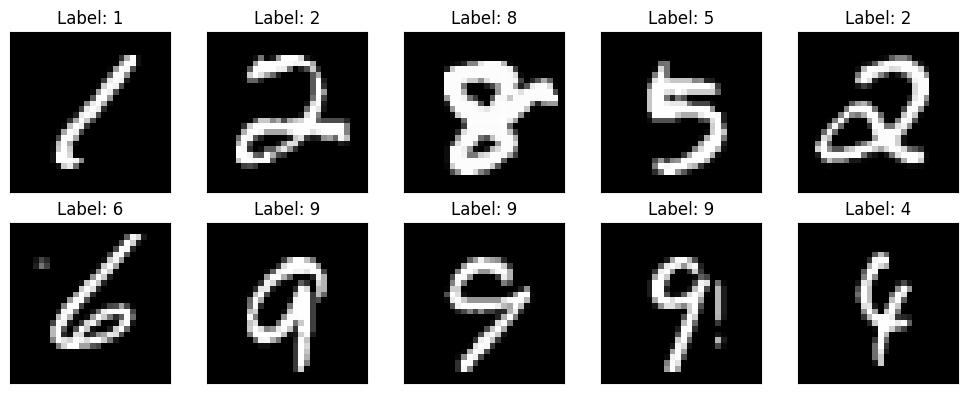

In [ ]:
# --- Data Transforms ---
# Normalize images to range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
print("Defined transforms:\n", transform)

# --- Load Dataset ---
print(f"\nLoading MNIST dataset from/to '{DATA_PATH}'...")
try:
    train_dataset = datasets.MNIST(root=DATA_PATH, train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root=DATA_PATH, train=False, transform=transform, download=True)
    print("MNIST dataset successfully loaded/downloaded.")
except Exception as e:
    print(f"Error loading/downloading dataset: {e}")

# --- Create DataLoaders ---
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print(f"Created train_loader with {len(train_loader)} batches (batch size {BATCH_SIZE}).")
print(f"Created test_loader with {len(test_loader)} batches (batch size {BATCH_SIZE}).")


# --- Visualize Sample Images ---
print("\nSample images from the training set:")
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(10, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    img = images[idx] / 2 + 0.5  # Denormalize for visualization
    img = img.numpy().squeeze()
    plt.imshow(img, cmap='gray')
    ax.set_title(f"Label: {labels[idx].item()}")
plt.tight_layout()
plt.show()

---
## 4. Model Architecture (CNN Classifier)

This section defines the CNN architecture for MNIST classification. The model follows a standard convolutional design optimized for digit recognition.

### Architecture Overview

| Layer | Type | Output Shape | Parameters |
|-------|------|--------------|------------|
| Input | — | 1×28×28 | — |
| Conv Block 1 | Conv2d(1→32, k=5) + ReLU + MaxPool | 32×14×14 | 832 |
| Conv Block 2 | Conv2d(32→64, k=5) + ReLU + MaxPool | 64×7×7 | 51,264 |
| Flatten | — | 3,136 | — |
| FC Block | Linear(3136→1024) + ReLU + Linear(1024→10) | 10 | 3,221,514 |

**Total Parameters:** ~3.27M trainable parameters

### Design Rationale
This architecture is deliberately kept simple yet effective, as it serves primarily as an evaluation tool for GAN-generated samples rather than as a state-of-the-art classifier. The same architecture is used in both ACGAN and QACGAN training notebooks for consistency.

In [ ]:
class MnistClassifier(nn.Module):
    """
    Convolutional Neural Network for MNIST digit classification.
    
    Architecture:
        - Conv Block 1: Conv2d(1→32, k=5) + ReLU + MaxPool2d
        - Conv Block 2: Conv2d(32→64, k=5) + ReLU + MaxPool2d
        - FC Block: Linear(3136→1024) + ReLU + Linear(1024→10)
    
    Args:
        num_classes: Number of output classes (default: 10 for digits 0-9)
    
    Returns:
        logits: Unnormalized class scores of shape (batch_size, num_classes)
    """
    def __init__(self, num_classes=10):
        super(MnistClassifier, self).__init__()

        # First convolutional block: 1→32 channels, 28x28→14x14
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Second convolutional block: 32→64 channels, 14x14→7x7
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Flattened feature size: 64 channels × 7 × 7 spatial
        self.flatten_size = 64 * 7 * 7

        # Fully connected classification head
        self.fc_block = nn.Sequential(
            nn.Linear(self.flatten_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(x.size(0), -1)  # Flatten spatial dimensions
        logits = self.fc_block(x)
        return logits

# --- Initialize model and transfer to appropriate device ---
classifier = MnistClassifier(num_classes=10).to(DEVICE)
print("Model Architecture:")
print(classifier)

# Optional: Display model summary with parameter count (requires `pip install torchsummary`)
try:
    from torchsummary import summary
    summary(classifier, input_size=(1, 28, 28))
except ImportError:
    print("\ntorchsummary library not installed. Install with `pip install torchsummary` for detailed model summary.")

Model Architecture:
MnistClassifier(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Linear(in_features=3136, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]      

---
## 5. Model Training

This section defines the loss function, optimizer, and executes the training loop. Training progress is monitored via loss curves.

### Optimization Setup
- **Loss Function:** CrossEntropyLoss (standard for multi-class classification)
- **Optimizer:** Adam with $\beta_1 = 0.9$, $\beta_2 = 0.999$
- **Learning Rate:** 0.001 (no scheduling)

### Training Protocol
The model trains for 10 epochs with batch-wise gradient updates. Loss is averaged per epoch and visualized after training completion.


Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

--- Starting Training ---
	Epoch: 1/10 | Batch: 100/469 | Avg Batch Loss: 0.1692
	Epoch: 1/10 | Batch: 200/469 | Avg Batch Loss: 0.2728
	Epoch: 1/10 | Batch: 300/469 | Avg Batch Loss: 0.0844
	Epoch: 1/10 | Batch: 400/469 | Avg Batch Loss: 0.0558
Epoch 1/10 completed | Average Training Loss: 0.1688 | Duration: 18.71s
	Epoch: 2/10 | Batch: 100/469 | Avg Batch Loss: 0.0518
	Epoch: 2/10 | Batch: 200/469 | Avg Batch Loss: 0.0113
	Epoch: 2/10 | Batch: 300/469 | Avg Batch Loss: 0.0033
	Epoch: 2/10 | Batch: 400/469 | Avg Batch Loss: 0.0473
Epoch 2/10 completed | Average Training Loss: 0.0429 | Duration: 14.19s
	Epoch: 3/10 | Batch: 100/469 | Avg Batch Loss: 0.0149
	Epoch: 3/10 | Batch: 200/469 | Avg Batch Loss: 0.0216
	Epoch: 3/10

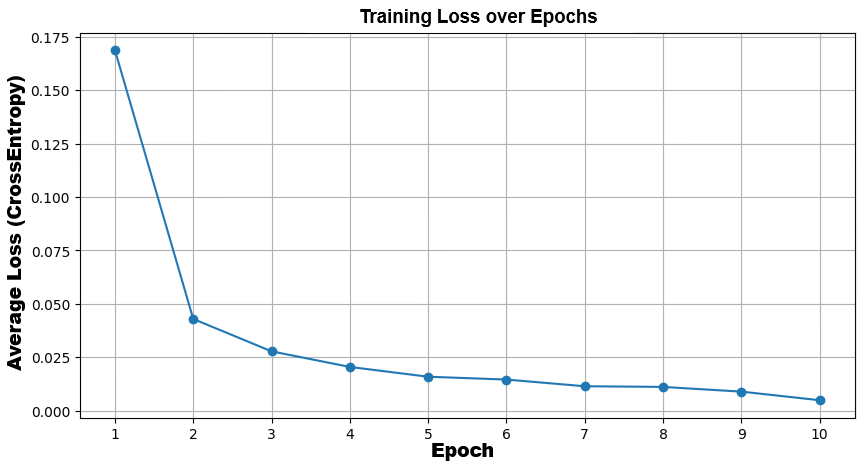

In [ ]:
# --- Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=LEARNING_RATE)

print(f"\nLoss Function: {criterion}")
print(f"Optimizer: {optimizer}")

# --- Training Loop ---
print("\n--- Starting Training ---")
start_time = time.time()
train_losses = []

classifier.train()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    running_loss = 0.0
    processed_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)

        # Zero gradients from previous iteration
        optimizer.zero_grad()

        # Forward pass
        outputs = classifier(data)
        loss = criterion(outputs, target)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Accumulate loss statistics
        running_loss += loss.item() * data.size(0)
        processed_samples += data.size(0)

        # Log progress every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f"\tEpoch: {epoch+1}/{EPOCHS} | Batch: {batch_idx+1}/{len(train_loader)} | "
                  f"Avg Batch Loss: {loss.item():.4f}")

    # Compute average loss for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    print(f"Epoch {epoch+1}/{EPOCHS} completed | Avg Training Loss: {epoch_loss:.4f} | "
          f"Duration: {epoch_duration:.2f}s")

end_time = time.time()
total_training_time = end_time - start_time
print(f"--- Training Completed ---")
print(f"Total training time: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)")

# --- Visualize Training Loss Curve ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', linestyle='-')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Loss (CrossEntropy)")
plt.xticks(range(1, EPOCHS + 1))
plt.grid(True)
plt.show()

---
## 6. Model Evaluation

After training, the model is evaluated on the held-out test set to measure generalization performance. The expected accuracy on MNIST is approximately **99%**, which provides a reliable baseline for evaluating GAN-generated samples.

### Evaluation Metrics
- **Test Loss:** Average CrossEntropyLoss on test set
- **Test Accuracy:** Percentage of correctly classified samples

### Visual Inspection
Sample predictions are displayed with color-coded labels:
- 🟢 **Green:** Correct prediction
- 🔴 **Red:** Incorrect prediction


--- Starting Evaluation on Test Set ---

Test Set Results:
  Average Loss: 0.0330
  Accuracy: 9910/10000 (99.10%)

Sample predictions on the test set:


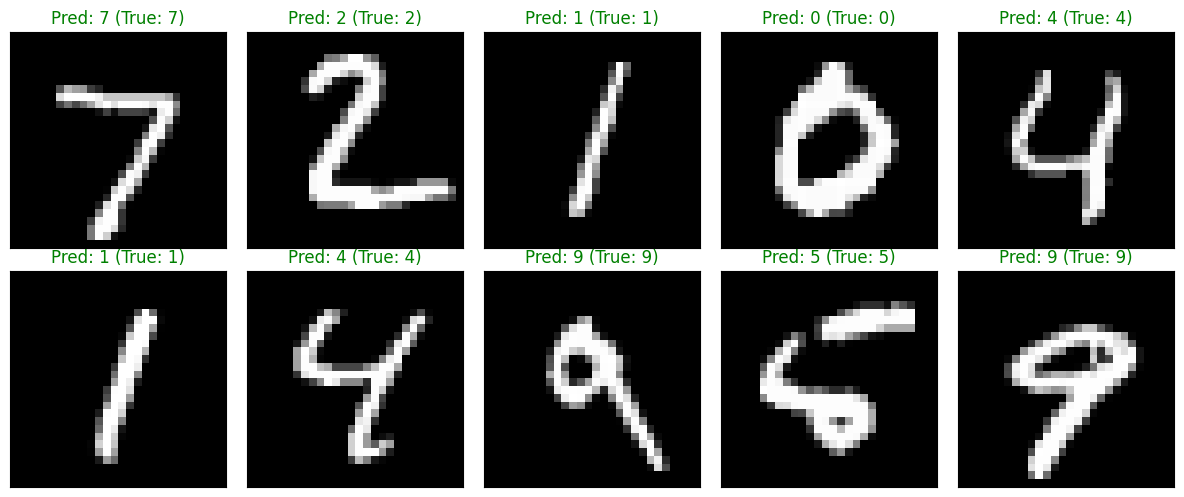

In [ ]:
print("\n--- Starting Evaluation on Test Set ---")
classifier.eval()

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        outputs = classifier(data)
        loss = criterion(outputs, target)

        # Accumulate test statistics
        test_loss += loss.item() * data.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

# Compute average loss and overall accuracy
avg_test_loss = test_loss / len(test_loader.dataset)
accuracy = 100. * correct / total

print(f"\nTest Set Results:")
print(f"  Average Loss: {avg_test_loss:.4f}")
print(f"  Accuracy: {correct}/{total} ({accuracy:.2f}%)")


# --- Visualize Sample Predictions ---
print("\nSample predictions on the test set:")
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(DEVICE), labels.to(DEVICE)

with torch.no_grad():
    outputs = classifier(images)
    _, predicted = torch.max(outputs, 1)

images_np = images.cpu().numpy()

fig = plt.figure(figsize=(12, 5))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    img = images_np[idx] / 2 + 0.5  # Denormalize for visualization
    img = img.squeeze()
    plt.imshow(img, cmap='gray')
    ax.set_title(f"Pred: {predicted[idx].item()} (True: {labels[idx].item()})",
                 color=("green" if predicted[idx]==labels[idx] else "red"))
plt.tight_layout()
plt.show()

---
## 7. Model Export

The trained model weights (`state_dict`) are saved to a `.pth` file for later use in GAN evaluation pipelines. In Google Colab, the file is automatically offered for download.

### Output File
- **Filename:** `mnist_classifier.pth`
- **Contents:** Model state dictionary (weights and biases)
- **Usage:** Load with `model.load_state_dict(torch.load('mnist_classifier.pth'))`

In [ ]:
# --- Save Model State Dictionary ---
torch.save(classifier.state_dict(), CLASSIFIER_SAVE_PATH)
print(f"\nModel (state_dict) successfully saved to: '{CLASSIFIER_SAVE_PATH}'")

# --- Download File from Colab ---
print(f"Initiating download of '{CLASSIFIER_SAVE_PATH}'...")
try:
    files.download(CLASSIFIER_SAVE_PATH)
    print("Download started. The file should appear in your browser.")
except Exception as e:
    print(f"Error during file download: {e}")
    print("You can manually download the file from the 'Files' panel on the left in Colab.")


Model (state_dict) successfully saved to: 'mnist_classifier.pth'
Initiating download of 'mnist_classifier.pth'...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started. The file should appear in your browser.


---
## 8. Model Verification

This section demonstrates how to load the saved model weights into a fresh model instance and verifies that the save/load process was successful by re-running evaluation.

### Verification Protocol
1. Create a new `MnistClassifier` instance
2. Load the saved `state_dict`
3. Run evaluation on the test set
4. Compare metrics with the original evaluation

If both evaluations produce identical results, the model was saved and loaded correctly.

In [ ]:
print("\n--- Model Loading Verification ---")

# Step 1: Create a new instance of the same architecture
loaded_classifier = MnistClassifier(num_classes=10).to(DEVICE)
print("New model instance created.")

# Step 2: Load the saved state_dict
try:
    loaded_classifier.load_state_dict(torch.load(CLASSIFIER_SAVE_PATH, map_location=DEVICE))
    print(f"State_dict successfully loaded from '{CLASSIFIER_SAVE_PATH}'.")

    # Step 3: Switch to evaluation mode
    loaded_classifier.eval()

    # Step 4: Re-run evaluation with the loaded model
    print("Running re-evaluation with loaded model...")
    re_test_loss = 0.0
    re_correct = 0
    re_total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = loaded_classifier(data)
            loss = criterion(outputs, target)
            re_test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            re_total += target.size(0)
            re_correct += (predicted == target).sum().item()

    re_avg_test_loss = re_test_loss / len(test_loader.dataset)
    re_accuracy = 100. * re_correct / re_total
    print(f"  Re-evaluation - Average Loss: {re_avg_test_loss:.4f}")
    print(f"  Re-evaluation - Accuracy: {re_correct}/{re_total} ({re_accuracy:.2f}%)")

    # Compare results (should be virtually identical if save/load was successful)
    if abs(avg_test_loss - re_avg_test_loss) < 1e-5 and abs(accuracy - re_accuracy) < 1e-2:
        print("Re-evaluation results match original evaluation. Model was loaded correctly.")
    else:
        print("Warning: Re-evaluation results differ from original evaluation!")

except FileNotFoundError:
    print(f"Error: File '{CLASSIFIER_SAVE_PATH}' not found for loading.")
except Exception as e:
    print(f"Error during model loading or verification: {e}")


--- Model Loading Verification ---
New model instance created.
State_dict successfully loaded from 'mnist_classifier.pth'.
Running re-evaluation with loaded model...
  Re-evaluation - Average Loss: 0.0330
  Re-evaluation - Accuracy: 9910/10000 (99.10%)
Re-evaluation results match original evaluation. Model was loaded correctly.


---
## 9. Conclusion

This notebook successfully trained a CNN classifier achieving **~99% accuracy** on the MNIST test set. The exported model (`mnist_classifier.pth`) serves as an **external evaluator** for measuring the class consistency of GAN-generated samples.

### Usage in GAN Evaluation
In our ACGAN and QACGAN experiments, this classifier evaluates 500 generated samples per evaluation step:
1. Generate samples for each digit class (0–9)
2. Pass samples through the classifier
3. Compare predicted labels with intended generation labels
4. Report classification accuracy as a measure of class conditioning quality

### Key Results
| Metric | Value |
|--------|-------|
| Test Accuracy | ~99% |
| Training Time | < 2 minutes (GPU) |
| Model Size | ~13 MB |

> **Note:** The high accuracy on MNIST makes this classifier a reliable evaluator—any significant drop in accuracy when classifying GAN-generated samples indicates poor class conditioning or mode collapse in the generator.